In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import math
import matplotlib.pyplot as plt

In [34]:
device_id = 2
device_name = f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu'
DEVICE = torch.device(device_name)
print('Using {} device'.format(DEVICE))

def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_random_seed(2)

Using cuda:2 device


In [3]:
class Drift(nn.Module):
    def __init__(self, input_dim):
        super(Drift, self).__init__()
        self.embedder = torch.nn.Sequential(
            torch.nn.Linear(input_dim+1, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, input_dim)
        )

    def forward(self, x_t, t):
        X = torch.cat((x_t, t), dim=1)
        return self.embedder(X)

class drift_gaussian_gaussian_multi(nn.Module):
    def __init__(self, mu1, Sigma1):
        super(drift_gaussian_gaussian_multi, self).__init__()
        self.d = Sigma1.size(0)
        self.mu1 = mu1
        self.mu0 = torch.zeros(self.d).float().to(DEVICE)
        self.Sigma1 = Sigma1
        self.Sigma0 = torch.eye(self.d).float().to(DEVICE)

    def forward(self, x_t, t):
        n, d = x_t.shape
        assert d == self.d
        ones = torch.ones_like(t).to(t.device)
        
        Sigma_t_inv = torch.inverse(self.Sigma1 * t.view(n, 1, 1)**2 + 
                                    self.Sigma0 * (1-t.view(n, 1, 1))**2)
        # Broadcasting t to match the shape of x_t
        t_broadcasted = t.expand(n, d)

        # Initialize v_t with the same shape as x_t
        v_t = torch.zeros_like(x_t)

        # Broadcasting mu0 and mu1 to match x_t
        mu0_broadcasted = self.mu0.expand(n, d)
        mu1_broadcasted = self.mu1.expand(n, d)

        # Indices where t == 1
        indices_t1 = (t_broadcasted == ones)
        v_t[indices_t1] = (x_t - mu0_broadcasted)[indices_t1]

        # Indices where t == 0
        indices_t0 = (t_broadcasted == 0)
        v_t[indices_t0] = (mu1_broadcasted - x_t)[indices_t0]

        # For all other cases
        indices_else = ~(indices_t1 | indices_t0)

        print(x_t.size(), Sigma_t_inv.size(), torch.matmul(x_t.view(n, d, 1), (self.Sigma0 - (1 - t.view(n, 1, 1))*Sigma_t_inv)).size())
        v_t[indices_else] = (torch.matmul(x_t, (self.Sigma0 - (1 - t.view(n, 1, 1))*Sigma_t_inv)) / t_broadcasted 
                             + torch.matmul(mu1_broadcasted, (1 - t.view(n, 1, 1))*Sigma_t_inv)).expand_as(x_t)[indices_else]

        return v_t

class drift_gaussian_gaussian(nn.Module):
    def __init__(self, mu0, mu1, sigma2_0, sigma2_1):
        super(drift_gaussian_gaussian, self).__init__()
        self.mu0 = mu0
        self.mu1 = mu1
        self.sigma2_0 = sigma2_0
        self.sigma2_1 = sigma2_1

    def score(self, x_t, t):
        sigma2_t = self.sigma2_1*t*t + self.sigma2_0*(1-t)*(1-t)
        mu_t = self.mu1*t + self.mu0*(1-t)
        s_t = (mu_t - x_t)/sigma2_t
        return s_t

    def forward(self, x_t, t):
        n, d = x_t.shape
        ones = torch.ones_like(t).to(t.device)

        # Broadcasting t to match the shape of x_t
        t_broadcasted = t.expand(n, d)

        # Initialize v_t with the same shape as x_t
        v_t = torch.zeros_like(x_t)

        # Broadcasting mu0 and mu1 to match x_t
        mu0_broadcasted = self.mu0.expand(n, d)
        mu1_broadcasted = self.mu1.expand(n, d)

        # Indices where t == 1
        indices_t1 = (t_broadcasted == ones)
        v_t[indices_t1] = (x_t - mu0_broadcasted)[indices_t1]

        # Indices where t == 0
        indices_t0 = (t_broadcasted == 0)
        v_t[indices_t0] = (mu1_broadcasted - x_t)[indices_t0]

        # For all other cases
        indices_else = ~(indices_t1 | indices_t0)
        v_t[indices_else] = (x_t / t_broadcasted + ((1 - t_broadcasted) / t_broadcasted) * self.sigma2_0 * self.score(x_t, t)).expand_as(x_t)[indices_else]

        return v_t

class CustomDataset(Dataset):
    def __init__(self, X, Z):
        self.X = X
        self.Z = Z

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Z[idx]

In [4]:
# Training loop

def train(model, num_epochs, dataloader, save_loss):
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0

        for batch in dataloader:
            x, z = batch
            m, d = z.size(0), z.size(1)

            # perm = torch.randperm(m)
            # x = x[perm, :].to(DEVICE).float()
            # z = z[perm, :].to(DEVICE).float()
            
            x = x.to(DEVICE).float()
            z = z.to(DEVICE).float() 

            x = x.unsqueeze(0).repeat(m, 1, 1).reshape(-1, d)
            z = z.unsqueeze(1).repeat(1, m, 1).reshape(-1, d)

            t = torch.from_numpy(np.random.uniform(0, 1, z.size(0))).to(DEVICE).float().view(-1, 1)
            x_t = t*x + (1-t)*z

            # Zero the parameter gradients
            model_optimizer.zero_grad()

            # Compute loss
            loss = criterion(model(x_t, t), (x-z))

            # Backward pass and optimize
            loss.backward()
            model_optimizer.step()
            
            # Accumulate loss
            epoch_loss += loss.item()
            num_batches += 1
        
        # Calculate and print average loss for the epoch
        avg_loss = epoch_loss / num_batches
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

        # Step the scheduler with the average loss
        scheduler.step(avg_loss)

        save_loss.append(avg_loss)
    
    return save_loss


def plot_loss(save_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(save_loss, marker='o', linestyle='-', color='b')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    plt.close()
    return

In [35]:
def sample(model, T, num_samples, input_dim):
    Z_0_np = np.random.multivariate_normal(np.zeros(input_dim), np.eye(input_dim), num_samples)

    Z_0 = torch.from_numpy(Z_0_np).to(DEVICE).float()

    with torch.no_grad():
        ones = torch.ones((num_samples, 1)).float().to(DEVICE)
        trajectory = Z_0.unsqueeze(0).repeat(T+1, 1, 1)
        drift_save = model(trajectory[0, :, :], ones*0).repeat(T+1, 1, 1)

        for i in range(1, T+1):
            t_i_minus_1 = ones*(i-1)/T
            trajectory[i, :, :] = trajectory[i-1, :, :] + model(trajectory[i-1, :, :], t_i_minus_1)/T
            drift_save[i, :, :] = model(trajectory[i-1, :, :], t_i_minus_1)
    return trajectory, drift_save

def plot_trajectories(trajectory, plot_paths=True, plot_original=True):
    trajectory_np = trajectory.cpu().numpy()
    (T, n, d) = trajectory.shape
    if plot_paths:
        for i in range(n):
            particle_trajectory = trajectory_np[:, i, :]
            plt.plot(particle_trajectory[:, 0], particle_trajectory[:, 1], alpha=0.1, color="purple")
            
    plt.scatter(trajectory_np[T-1, :, 0], trajectory_np[T-1, :, 1], label="End points", color="green")
    plt.scatter(trajectory_np[0, :, 0], trajectory_np[0, :, 1], label="Initial points", color="orange")
    if plot_original: plt.scatter(X_np[:, 0], X_np[:, 1], label="Original data points", color="blue", alpha=0.05)
    
    plt.title('Trajectories of particles over time, T={}'.format(T-1))
    plt.legend()
    plt.show()
    plt.close()
    return

In [45]:
set_random_seed(2)
input_dim = 2
num_samples = 5000
sigma2_1 = 1
Z_np = np.random.multivariate_normal(np.zeros(input_dim), np.eye(input_dim), num_samples)

mean1 = [5, 9]
cov1 = [[1, -0.8], [-0.8, 1]]
cov1 = sigma2_1 * np.eye(input_dim)
# cov1 = np
# mean2 = [8, 3]
# cov2 = [[1, -0.5], [-0.5, 1]]

# Mixing proportions
weights = [1, 0]

# Determine the number of samples from each component
num_samples_component = np.random.multinomial(num_samples, weights)

# Generate the samples
X_np = np.vstack([
    np.random.multivariate_normal(mean1, cov1, num_samples_component[0])
])
np.random.shuffle(X_np)


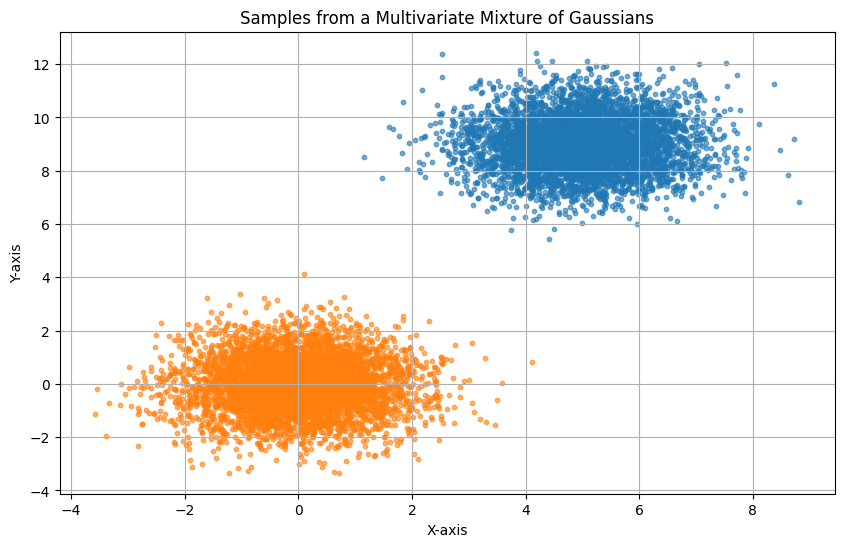

In [46]:
# Plot the samples
plt.figure(figsize=(10, 6))
plt.scatter(X_np[:, 0], X_np[:, 1], s=10, alpha=0.6)
plt.scatter(Z_np[:, 0], Z_np[:, 1],  s=10, alpha=0.6)
plt.title('Samples from a Multivariate Mixture of Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

In [62]:
# T euler steps
mu1 = torch.tensor(mean1).float().to(DEVICE)
mu0 = torch.tensor([0, 0]).float().to(DEVICE)
Sigma1 = torch.tensor(cov1).float().to(DEVICE)
true_drift = drift_gaussian_gaussian(mu0, mu1, sigma2_0=1, sigma2_1=sigma2_1)
# true_drift = drift_gaussian_gaussian_multi(mu1, Sigma1)
T = 2000
num_samples = 100


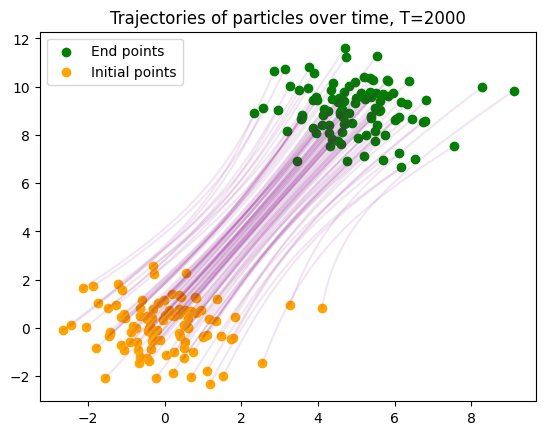

In [64]:
set_random_seed(2)
trajectory, save_drift = sample(true_drift, T, num_samples, 2)
plot_trajectories(trajectory, plot_paths=True, plot_original=False)

In [206]:
X_rec_1, Z_rec_1 = trajectory[T, :, :], trajectory[0, :, :]

dataset_1 = CustomDataset(X_rec_1, Z_rec_1)
dataloader_1 = DataLoader(dataset_1, batch_size=512, shuffle=True)

model_1 = Drift(input_dim).to(DEVICE).float()

criterion = nn.MSELoss()
num_epochs=250
# model_optimizer = optim.Adam(model.parameters(), lr=0.001)
model_optimizer = optim.Adam(model_1.parameters(), lr=0.01)
save_loss_1 = []
scheduler = ReduceLROnPlateau(model_optimizer, mode='min', factor=0.2, patience=5, verbose=True)

/home/vbansal/.conda/envs/ibc/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [177]:
save_loss = train(model_1, num_epochs, dataloader_1, save_loss_1)

Epoch [1/250], Average Loss: 232.6160
Epoch [2/250], Average Loss: 12.6278
Epoch [3/250], Average Loss: 7.0952
Epoch [4/250], Average Loss: 3.1272
Epoch [5/250], Average Loss: 2.1439
Epoch [6/250], Average Loss: 1.9489
Epoch [7/250], Average Loss: 1.8505
Epoch [8/250], Average Loss: 1.7752
Epoch [9/250], Average Loss: 1.7303
Epoch [10/250], Average Loss: 1.7029
Epoch [11/250], Average Loss: 1.6890
Epoch [12/250], Average Loss: 1.6800
Epoch [13/250], Average Loss: 1.6722
Epoch [14/250], Average Loss: 1.6595
Epoch [15/250], Average Loss: 1.6472
Epoch [16/250], Average Loss: 1.6433
Epoch [17/250], Average Loss: 1.6364
Epoch [18/250], Average Loss: 1.6396
Epoch [19/250], Average Loss: 1.6411
Epoch [20/250], Average Loss: 1.6355
Epoch [21/250], Average Loss: 1.6327
Epoch [22/250], Average Loss: 1.6165
Epoch [23/250], Average Loss: 1.6211
Epoch [24/250], Average Loss: 1.6119
Epoch [25/250], Average Loss: 1.6275
Epoch [26/250], Average Loss: 1.6484
Epoch [27/250], Average Loss: 1.6144
Epoch [

KeyboardInterrupt: 

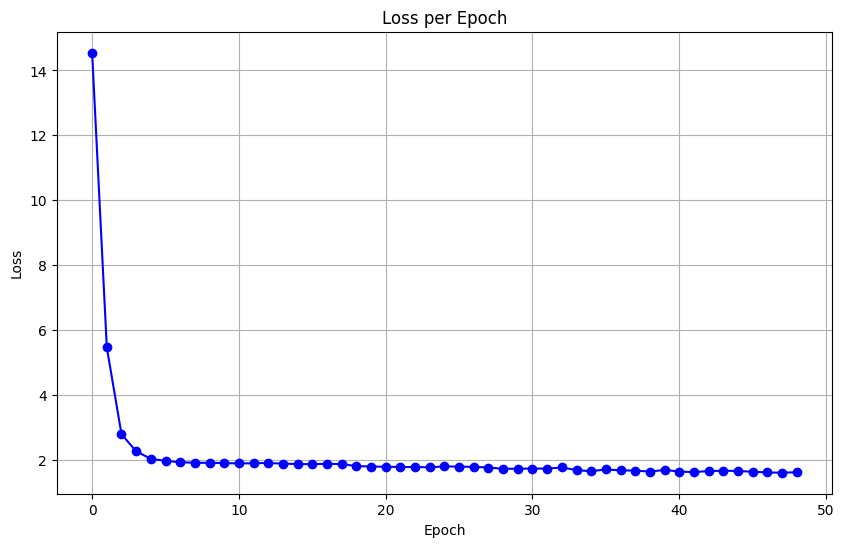

In [178]:
plot_loss(save_loss[1:])

In [183]:
T = 2
trajectory_1, save_drift_1 = sample(model_1, T, num_samples, 2)

In [207]:
(X_rec_1 - Z_rec_1 - mu1).int()

tensor([[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]], device='cuda:2', dtype=torch.int32)

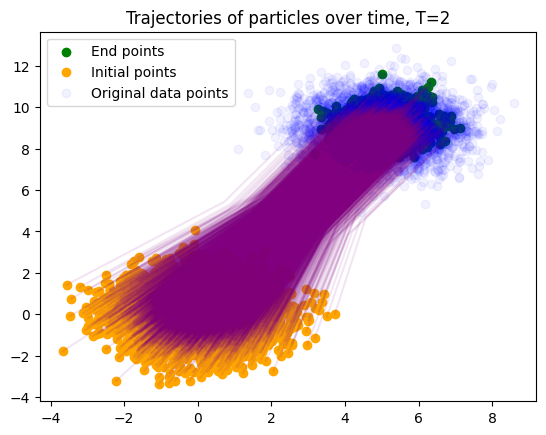

In [184]:
plot_trajectories(trajectory_1, plot_paths=True)